In [1]:
import gensim
from gensim import corpora, models
import nltk
from nltk.corpus import wordnet
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import time
from wordcloud import WordCloud



In [2]:
# Needed for tokenization
nltk.download('punkt')

# Needed for lemmatization
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/youngha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/youngha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youngha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/youngha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/youngha/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Preprocess Data

Note: The preprocessing steps are drawn from related background work by 
Xi and Xiaowei, as well as Zahoor et al. This is cited officially in the 
corresponding paper. 

In [4]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [5]:
# [nltk_tag_to_wordnet_tag] directly copied and pasted from:
# https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258
# with slight adaptations for the else case from: 
# https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [6]:
# code adapted from https://jenniferkwentoh.com/nltk-wordnet-python/
def get_antonym(word, pos):
    synsets = wordnet.synsets(word, pos) if pos else wordnet.synsets(word)
    
    for synset in synsets:
        for lemma in synset.lemmas():
            if lemma.antonyms():
                return lemma.antonyms()[0].name()
    
    return None


In [7]:
english_stopwords_for_remove_negation_during_preprocess = set(nltk.corpus.stopwords.words("english"))
english_stopwords_for_remove_negation_during_preprocess.add("ca")
english_stopwords_for_remove_negation_during_preprocess.add("n't")

def is_stopword_for_remove_negation_during_preprocess(word):
    return word.lower() in english_stopwords_for_remove_negation_during_preprocess

english_stopwords_for_include_negation_during_preprocess = set(nltk.corpus.stopwords.words("english"))
english_stopwords_for_include_negation_during_preprocess.add("ca")
english_stopwords_for_include_negation_during_preprocess.add("wo")
english_stopwords_for_include_negation_during_preprocess.remove("no")
english_stopwords_for_include_negation_during_preprocess.remove("nor")
english_stopwords_for_include_negation_during_preprocess.remove("not")

def is_stopword_for_include_negation_during_preprocess(word):
    return word.lower() in english_stopwords_for_include_negation_during_preprocess


In [10]:
punctuation = set(string.punctuation)
def is_punctuation(word):
    return word in punctuation

def remove_urls(text):
    return re.sub(r'(https|http|www.)(\S)*', "", text)

def remove_numbers(text):
    return re.sub(r'\d', "", text)

In [11]:
# replace negatives
# code not copied but inspired from: https://www.youtube.com/watch?v=88yOCX4ZyoA&ab_channel=RockyDeRaze

def preprocess(text, remove_negation_during_preprocess=True):
    # remove urls and numbers
    text = remove_urls(text)
    text = remove_numbers(text)
    
    tokens = nltk.word_tokenize(text)
    words_with_pos = nltk.pos_tag(tokens)
    words_with_wordnet_pos = [(word, nltk_tag_to_wordnet_tag(pos)) for (word, pos) in words_with_pos]    
    
    # lemmatize word
    lemmatized_tokens = []
    for (token, pos) in words_with_wordnet_pos:
        pos = pos if pos else wordnet.NOUN
        lemmatized_tokens.append((lemmatizer.lemmatize(token, pos), pos))
    
    if remove_negation_during_preprocess:
        # handle basic negations
        idx = len(lemmatized_tokens) - 1
        filtered_tokens = []

        while idx >= 0:
            prev_word, prev_pos = lemmatized_tokens[idx - 1] if idx > 0 else (None, None)
            cur_word, cur_pos = lemmatized_tokens[idx]
            cur_word_antonym = get_antonym(cur_word, cur_pos)

            if prev_word in ["not", "n't", "never", "no", "nor"] and cur_word_antonym:
                filtered_tokens.append((cur_word_antonym, cur_pos))
                idx -= 2
            else:
                filtered_tokens.append((cur_word, cur_pos))
                idx -= 1

        # remove stop words and punctuation
        filtered_tokens = [token for (token, pos) in filtered_tokens if not 
                            is_stopword_for_remove_negation_during_preprocess(token)
                            and not is_punctuation(token)]
        filtered_tokens.reverse()
        
    else:
        # remove stop words and punctuation
        filtered_tokens = [token for (token, pos) in lemmatized_tokens if not 
                           is_stopword_for_include_negation_during_preprocess(token) 
                           and not is_punctuation(token)]

    # make tokens lowercase
    lowercase_tokens = [token.lower() for token in filtered_tokens]

    return lowercase_tokens


In [12]:
reviews = pd.read_csv("reviews_with_sentiment.csv")

/var/folders/sx/5y812tj93qvbxkbmjcc6jjk80000gn/T/ipykernel_75882/617990225.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("reviews_with_sentiment.csv")


In [13]:
# create new tokens field that contains preprocessed tokens
def tokens(review):
    tokens = preprocess(review.text)
    return ",".join(tokens)

reviews['tokens'] = reviews.apply(tokens, axis = 1)

In [14]:
def tokens_with_negation(review):
    tokens_with_negation = preprocess(review.text, remove_negation_during_preprocess=False)
    return ",".join(tokens_with_negation)

reviews['tokens_with_negation'] = reviews.apply(tokens_with_negation, axis = 1)

In [15]:
reviews.to_csv("reviews_with_tokens.csv")

# Aggregate word cloud

In [3]:
reviews = pd.read_csv("reviews_with_tokens.csv")
reviews = reviews.dropna(subset=["tokens", "tokens_with_negation"])

/var/folders/sx/5y812tj93qvbxkbmjcc6jjk80000gn/T/ipykernel_34906/460780110.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("reviews_with_tokens.csv")


In [4]:
reviews_asian = reviews[reviews["cuisine"] != "American European"]
reviews_eur = reviews[reviews["cuisine"] == "American European"]

In [5]:
def is_valid_time(review):
    return review.year >= 2010 and review.year <= 2021
    
reviews_asian = reviews_asian[reviews_asian.apply(is_valid_time, axis = 1)]
reviews_eur = reviews_eur[reviews_eur.apply(is_valid_time, axis = 1)]


In [6]:
def get_all_unigrams(df):
    return ",".join(df["tokens"].values).split(",")

def get_all_bigrams(df, use_tokens_with_negation):
    bigrams = []
    if use_tokens_with_negation:
        reviews_tokens = df["tokens_with_negation"].values        
    else:
        reviews_tokens = df["tokens"].values

    for reviews_idx in range(len(reviews_tokens)):
        tokens = reviews_tokens[reviews_idx].split(",")
        for idx in range(len(tokens) - 1):
            if tokens[idx] not in tokens_to_ignore and tokens[idx + 1] not in tokens_to_ignore:
                bigrams.append(f"{tokens[idx]} {tokens[idx + 1]}")
        
    return bigrams

def get_all_trigrams(df, use_tokens_with_negation):
    trigrams = []
    if use_tokens_with_negation:
        reviews_tokens = df["tokens_with_negation"].values
    else:
        reviews_tokens = df["tokens"].values
    for reviews_idx in range(len(reviews_tokens)):
        tokens = reviews_tokens[reviews_idx].split(",")
        for idx in range(len(tokens) - 2):
            if tokens[idx] not in tokens_to_ignore and tokens[idx + 1] not in tokens_to_ignore and tokens[idx + 2] not in tokens_to_ignore:
                trigrams.append(f"{tokens[idx]} {tokens[idx + 1]} {tokens[idx + 2]}")
        
    return trigrams

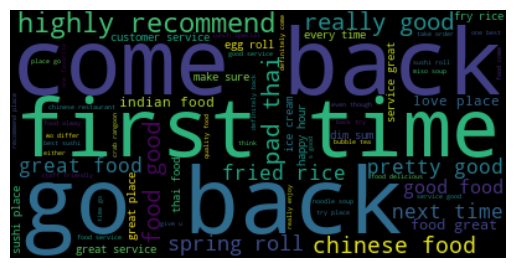

In [20]:
# Adapted from wordcloud package documentation:
# https://github.com/amueller/word_cloud/blob/main/examples/simple.py
tokens_asian = get_all_unigrams(reviews_asian)

wordcloud_asian = WordCloud().generate(" ".join(tokens_asian))
plt.imshow(wordcloud_asian, interpolation='bilinear')
plt.axis("off")
plt.show()

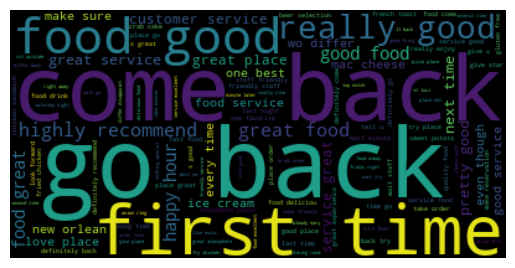

In [21]:
tokens_eur = get_all_unigrams(reviews_eur)

wordcloud_eur = WordCloud().generate(" ".join(tokens_eur))
plt.imshow(wordcloud_eur, interpolation='bilinear')
plt.axis("off")
plt.show()

# Frequency Analysis

## Set-up

In [7]:
tokens_to_ignore = ["'s", "'ve", "....", "...", "..", "also", "``", "u", "''", "'ll", "'d", "--", "'m",
                   "could", "would"]
start_year = 2010
end_year = 2021
k = 50

In [8]:
def get_unigrams_in_year(reviews, year, use_tokens_with_negation):
    reviews_in_year = reviews[reviews["year"] == year]
    return get_all_unigrams(reviews_in_year)

def get_bigrams_in_year(reviews, year, use_tokens_with_negation):
    reviews_in_year = reviews[reviews["year"] == year]
    return get_all_bigrams(reviews_in_year, use_tokens_with_negation)

def get_trigrams_in_year(reviews, year, use_tokens_with_negation):
    reviews_in_year = reviews[reviews["year"] == year]
    return get_all_trigrams(reviews_in_year, use_tokens_with_negation)


In [9]:
def get_top_k_tokens(tokens, k, tokens_to_ignore=tokens_to_ignore):
    word_freqs = {}
    for token in tokens:
        if token not in word_freqs:
            word_freqs[token] = 0
        word_freqs[token] += 1
    
    words_and_counts = list(zip(word_freqs.keys(), word_freqs.values()))
    sorted_words_and_counts = sorted(words_and_counts, key = lambda x: x[1], reverse = True)
        
    return [token for (token, count) in sorted_words_and_counts if token not in tokens_to_ignore][:k]

def print_tokens(tokens):
    for token in tokens:
        print(token)    
    print("\n")                
        

In [10]:
def print_top_k_for_years(reviews, start_year, end_year, k, get_tokens_in_year, use_tokens_with_negation=False):
    for year in range(start_year, end_year + 1):
        tokens = get_tokens_in_year(reviews, year, use_tokens_with_negation)
        top_k_tokens = get_top_k_tokens(tokens, k)
        print(f"Top {k} in Year {year}")
        for token in top_k_tokens:
            print(token)
        print("\n")    

In [11]:
# Difference between year to year for a cuisine
def difference_across_years(reviews, start_year, end_year, k, get_tokens_in_year, use_tokens_with_negation=False):
    for year in range(start_year, end_year):
        cur_year_tokens = get_top_k_tokens(get_tokens_in_year(reviews, year, use_tokens_with_negation), k)
        next_year_tokens = get_top_k_tokens(get_tokens_in_year(reviews, year + 1, use_tokens_with_negation), k)
        
        common_tokens = set(cur_year_tokens).intersection(next_year_tokens)
        
        print(f"Token Differences Between {year} and {year + 1}")
        
        # tokens that are removed
        print("Removed Tokens:")
        print(set(cur_year_tokens).difference(common_tokens))
        
        # tokens that are newly added
        print("Added Tokens:")
        print(set(next_year_tokens).difference(common_tokens))    
        
        print("\n")


In [12]:
# Difference between Asian and European cuisines from year to year
def print_difference_across_cuisines(tokens_asian, tokens_eur, year):
    common_tokens = set(tokens_asian).intersection(tokens_eur)

    print(f"Token Differences In {year}")

    # tokens that only Asian cuisine has
    print("Unique Asian Tokens:")
    print(set(tokens_asian).difference(common_tokens))

    # tokens that only European + American cuisine has
    print("Unique European + American Tokens:")
    print(set(tokens_eur).difference(common_tokens))    

    print("\n")    

def token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, k,
                                    get_tokens_in_year, use_tokens_with_negation=False):
    for year in range(start_year, end_year + 1):
        tokens_asian = get_top_k_tokens(get_tokens_in_year(reviews_asian, year, use_tokens_with_negation), k)
        tokens_eur = get_top_k_tokens(get_tokens_in_year(reviews_eur, year, use_tokens_with_negation), k)
        
        print_difference_across_cuisines(tokens_asian, tokens_eur, year)


## Unigrams

In [29]:
k = 50

### Tokens (Tokens With Negation Not Applicable To Unigrams)

#### All-time

In [30]:
all_unigrams_asian = get_all_unigrams(reviews_asian)
all_unigrams_eur = get_all_unigrams(reviews_eur)

print("Top k All Time Unigrams for Asian Cuisine")
print_tokens(get_top_k_tokens(all_unigrams_asian, k))

print("Top k All Time Unigrams for European + American Cuisine")
print_tokens(get_top_k_tokens(all_unigrams_eur, k))

Top k All Time Unigrams for Asian Cuisine
food
good
place
order
get
go
great
time
service
like
come
restaurant
try
sushi
chicken
one
roll
back
really
eat
make
delicious
dish
love
best
rice
well
take
menu
say
sauce
taste
fresh
nice
definitely
always
price
give
little
even
wait
soup
thai
lunch
want
spicy
flavor
table
first
friendly


Top k All Time Unigrams for European + American Cuisine
food
good
place
get
great
order
go
time
service
come
like
one
back
make
try
pizza
really
restaurant
say
wait
well
take
love
eat
delicious
menu
best
nice
drink
chicken
table
cheese
even
burger
bar
want
give
staff
fry
little
salad
definitely
friendly
meal
look
always
first
experience
ask
sauce




In [21]:
tokens_asian = get_top_k_tokens(all_unigrams_asian, k)
tokens_eur = get_top_k_tokens(all_unigrams_eur, k)

print_difference_across_cuisines(tokens_asian, tokens_eur, "All Time")

Token Differences In All Time
Unique Asian Tokens:
{'flavor', 'rice', 'taste', 'spicy', 'sushi', 'price', 'dish', 'soup', 'fresh', 'roll', 'lunch', 'thai'}
Unique European + American Tokens:
{'bar', 'fry', 'salad', 'cheese', 'drink', 'look', 'pizza', 'staff', 'ask', 'meal', 'experience', 'burger'}




#### Top K Per Year

In [22]:
print_top_k_for_years(reviews_asian, start_year, end_year, k, get_unigrams_in_year)

Top 50 in Year 2010
food
good
place
go
get
sushi
like
order
great
restaurant
roll
time
one
try
really
service
come
eat
dish
make
chicken
back
well
menu
say
best
little
love
sauce
rice
price
take
thai
lunch
nice
taste
pretty
think
chinese
soup
fresh
delicious
even
want
always
much
spicy
give
look
meal


Top 50 in Year 2011
food
good
place
go
get
order
like
sushi
great
time
roll
restaurant
one
service
come
try
really
chicken
eat
make
dish
back
menu
well
best
say
love
rice
take
sauce
little
price
nice
thai
taste
lunch
soup
delicious
fresh
even
chinese
pretty
think
give
always
spicy
want
much
table
look


Top 50 in Year 2012
food
good
place
get
go
order
like
sushi
great
time
restaurant
roll
service
come
try
one
really
chicken
eat
make
dish
back
well
menu
say
love
take
best
rice
sauce
little
price
nice
thai
taste
lunch
delicious
soup
even
fresh
give
want
think
pretty
always
spicy
chinese
table
much
look


Top 50 in Year 2013
food
good
place
go
get
order
like
great
time
sushi
restaurant
serv

In [23]:
print_top_k_for_years(reviews_eur, start_year, end_year, k, get_unigrams_in_year)

Top 50 in Year 2010
good
place
food
go
get
great
like
time
order
one
really
service
come
make
try
back
pizza
restaurant
well
eat
menu
say
bar
cheese
nice
love
little
best
take
beer
table
think
drink
even
burger
night
wait
want
pretty
salad
look
delicious
give
meal
fry
sauce
friend
chicken
taste
thing


Top 50 in Year 2011
good
food
place
get
go
great
like
order
time
one
service
really
come
make
back
try
restaurant
pizza
eat
well
say
menu
love
cheese
bar
nice
take
best
little
table
beer
burger
drink
think
wait
even
want
salad
night
delicious
pretty
look
give
sauce
fry
chicken
meal
taste
thing
much


Top 50 in Year 2012
good
food
place
go
get
great
order
like
time
one
service
come
really
make
back
try
restaurant
pizza
say
well
menu
eat
love
nice
take
cheese
bar
table
drink
best
wait
burger
little
beer
salad
want
even
delicious
think
give
chicken
night
meal
look
sauce
fry
taste
price
pretty
first


Top 50 in Year 2013
good
food
place
get
go
great
order
like
time
service
one
come
back
make

#### Difference Across Years For Same Cuisine

In [24]:
difference_across_years(reviews_asian, start_year, end_year, k, get_unigrams_in_year)

Token Differences Between 2010 and 2011
Removed Tokens:
{'meal'}
Added Tokens:
{'table'}


Token Differences Between 2011 and 2012
Removed Tokens:
set()
Added Tokens:
set()


Token Differences Between 2012 and 2013
Removed Tokens:
{'much'}
Added Tokens:
{'definitely'}


Token Differences Between 2013 and 2014
Removed Tokens:
{'think', 'pretty', 'look'}
Added Tokens:
{'wait', 'friendly', 'first'}


Token Differences Between 2014 and 2015
Removed Tokens:
{'chinese'}
Added Tokens:
{'look'}


Token Differences Between 2015 and 2016
Removed Tokens:
{'look'}
Added Tokens:
{'flavor'}


Token Differences Between 2016 and 2017
Removed Tokens:
{'first'}
Added Tokens:
{'staff'}


Token Differences Between 2017 and 2018
Removed Tokens:
{'table', 'thai'}
Added Tokens:
{'recommend', 'first'}


Token Differences Between 2018 and 2019
Removed Tokens:
{'first'}
Added Tokens:
{'noodle'}


Token Differences Between 2019 and 2020
Removed Tokens:
{'noodle', 'little', 'lunch'}
Added Tokens:
{'thai', 'favori

In [25]:
difference_across_years(reviews_eur, start_year, end_year, k, get_unigrams_in_year)

Token Differences Between 2010 and 2011
Removed Tokens:
{'friend'}
Added Tokens:
{'much'}


Token Differences Between 2011 and 2012
Removed Tokens:
{'thing', 'much'}
Added Tokens:
{'price', 'first'}


Token Differences Between 2012 and 2013
Removed Tokens:
set()
Added Tokens:
set()


Token Differences Between 2013 and 2014
Removed Tokens:
{'think', 'pretty', 'price'}
Added Tokens:
{'always', 'staff', 'friendly'}


Token Differences Between 2014 and 2015
Removed Tokens:
{'taste', 'night'}
Added Tokens:
{'definitely', 'experience'}


Token Differences Between 2015 and 2016
Removed Tokens:
{'sauce', 'beer'}
Added Tokens:
{'server', 'ask'}


Token Differences Between 2016 and 2017
Removed Tokens:
set()
Added Tokens:
set()


Token Differences Between 2017 and 2018
Removed Tokens:
set()
Added Tokens:
set()


Token Differences Between 2018 and 2019
Removed Tokens:
set()
Added Tokens:
set()


Token Differences Between 2019 and 2020
Removed Tokens:
{'server', 'bar'}
Added Tokens:
{'sauce', 'rec

#### Difference Across Cuisines For Each Year

In [26]:
token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, 50, get_unigrams_in_year)

Token Differences In 2010
Unique Asian Tokens:
{'always', 'chinese', 'rice', 'sushi', 'price', 'much', 'dish', 'thai', 'spicy', 'fresh', 'roll', 'lunch', 'soup'}
Unique European + American Tokens:
{'bar', 'night', 'thing', 'wait', 'fry', 'salad', 'cheese', 'beer', 'drink', 'pizza', 'friend', 'table', 'burger'}


Token Differences In 2011
Unique Asian Tokens:
{'always', 'chinese', 'rice', 'sushi', 'price', 'thai', 'dish', 'spicy', 'fresh', 'roll', 'lunch', 'soup'}
Unique European + American Tokens:
{'bar', 'night', 'thing', 'wait', 'fry', 'salad', 'cheese', 'drink', 'pizza', 'beer', 'meal', 'burger'}


Token Differences In 2012
Unique Asian Tokens:
{'always', 'chinese', 'rice', 'spicy', 'sushi', 'much', 'dish', 'soup', 'fresh', 'roll', 'lunch', 'thai'}
Unique European + American Tokens:
{'first', 'bar', 'night', 'wait', 'fry', 'salad', 'cheese', 'drink', 'pizza', 'beer', 'meal', 'burger'}


Token Differences In 2013
Unique Asian Tokens:
{'always', 'chinese', 'rice', 'sushi', 'thai', 'di

## Bigrams

### Tokens

#### All-time

In [31]:
all_bigrams_asian = get_all_bigrams(reviews_asian, use_tokens_with_negation=False)
all_bigrams_eur = get_all_bigrams(reviews_eur, use_tokens_with_negation=False)

print("Top k All Timea Bigrams for Asian Cuisine")
print_tokens(get_top_k_tokens(all_bigrams_asian, k))

print("Top k All Time Bigrams for European + American Cuisine")
print_tokens(get_top_k_tokens(all_bigrams_eur, k))

Top k All Time Bigrams for Asian Cuisine


KeyboardInterrupt: 

In [33]:
tokens_asian = get_top_k_tokens(all_bigrams_asian, k)
tokens_eur = get_top_k_tokens(all_bigrams_eur, k)

print_difference_across_cuisines(tokens_asian, tokens_eur, "All Time")

Token Differences In All Time
Unique Asian Tokens:
{'pad thai', 'egg roll', 'spring roll', 'thai food', 'lunch special', 'chinese restaurant', 'indian food', 'fried rice', 'chinese food', 'sushi roll', 'try place', 'dim sum', 'sushi place', 'fry rice'}
Unique European + American Tokens:
{'french toast', 'wait minute', 'take order', 'wait staff', 'get food', 'mac cheese', 'beer selection', 'long time', 'seem like', 'sweet potato', 'new orleans', 'last night', 'really enjoy', 'time go'}




#### Top K Per Year

In [ ]:
print_top_k_for_years(reviews_asian, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=False)

In [ ]:
print_top_k_for_years(reviews_eur, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=False)

#### Difference Across Years For Same Cuisine

In [ ]:
difference_across_years(reviews_asian, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=False)

In [ ]:
difference_across_years(reviews_eur, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=False)

#### Difference Across Cuisines For Each Year

In [ ]:
token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, k, 
                                 get_bigrams_in_year, use_tokens_with_negation=False)

### Tokens With Negation

#### All-time

In [45]:
all_bigrams_asian = get_all_bigrams(reviews_asian, use_tokens_with_negation=True)
all_bigrams_eur = get_all_bigrams(reviews_eur, use_tokens_with_negation=True)

print("Top k All Time Bigrams for Asian Cuisine")
print_tokens(get_top_k_tokens(all_bigrams_asian, k))

print("Top k All Time Bigrams for European + American Cuisine")
print_tokens(get_top_k_tokens(all_bigrams_eur, k))

Top k All Time Bigrams for Asian Cuisine
come back
go back
first time
highly recommend
really good
pad thai
chinese food
food good
spring roll
pretty good
fried rice
great food
next time
good food
love place
food great
taste like
indian food
great service
customer service
egg roll
n't know
thai food
service great
n't even
ice cream
every time
n't get
make sure
not sure
n't wait
fry rice
happy hour
sushi place
dim sum
great place
not good
staff friendly
n't go
lunch special
good service
one best
definitely back
sushi roll
even though
food come
food delicious
feel like
food service
look like


Top k All Time Bigrams for European + American Cuisine
go back
come back
first time
really good
highly recommend
food good
great food
good food
happy hour
great service
next time
pretty good
food great
customer service
great place
n't even
service great
n't get
taste like
n't know
make sure
love place
not sure
n't wait
ice cream
n't go
new orleans
food service
good service
mac cheese
one best
every

In [46]:
tokens_asian = get_top_k_tokens(all_bigrams_asian, k)
tokens_eur = get_top_k_tokens(all_bigrams_eur, k)

print_difference_across_cuisines(tokens_asian, tokens_eur, "All Time")

Token Differences In All Time
Unique Asian Tokens:
{'pad thai', 'egg roll', 'spring roll', 'thai food', 'lunch special', 'indian food', 'fried rice', 'chinese food', 'sushi roll', 'dim sum', 'sushi place', 'fry rice'}
Unique European + American Tokens:
{"n't want", 'place go', 'take order', 'wait staff', 'get food', 'mac cheese', 'good not', 'service good', 'no one', 'new orleans', 'last night', 'really enjoy'}




#### Top K Per Year

In [ ]:
print_top_k_for_years(reviews_asian, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=True)

In [ ]:
print_top_k_for_years(reviews_eur, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=True)

#### Difference Across Years For Same Cuisine

In [ ]:
difference_across_years(reviews_asian, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=True)

In [ ]:
difference_across_years(reviews_eur, start_year, end_year, k, get_bigrams_in_year, use_tokens_with_negation=True)

#### Difference Across Cuisines For Each Year

In [47]:
token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, k, 
                                 get_bigrams_in_year, use_tokens_with_negation=True)

Token Differences In 2010
Unique Asian Tokens:
{'pad thai', 'egg roll', 'spring roll', 'thai food', 'lunch special', 'chinese restaurant', 'indian food', 'sushi bar', 'miso soup', 'fried rice', 'spicy tuna', 'chinese food', 'dim sum', 'sushi place'}
Unique European + American Tokens:
{'good place', 'wait staff', 'good not', 'beer selection', 'one best', 'great service', 'seem like', "n't wait", 'sweet potato', 'new orleans', 'last night', 'st. louis', 'really like', 'not great'}


Token Differences In 2011
Unique Asian Tokens:
{'pad thai', 'egg roll', 'spring roll', 'thai food', 'chinese restaurant', 'lunch special', 'indian food', 'sushi bar', 'miso soup', 'fried rice', 'spicy tuna', 'chinese food', "food n't", 'dim sum', 'sushi place'}
Unique European + American Tokens:
{'good place', 'wait staff', 'happy hour', 'beer selection', 'one best', 'mac cheese', 'seem like', 'service good', "n't think", "n't wait", 'sweet potato', 'new orleans', 'service great', 'really like', 'food service

## Trigrams

### Tokens

#### All-time

In [ ]:
all_trigrams_asian = get_all_trigrams(reviews_asian, use_tokens_with_negation=False)
all_trigrams_eur = get_all_trigrams(reviews_eur, use_tokens_with_negation=False)

print("Top k All Time Trigrams for Asian Cuisine")
print_tokens(get_top_k_tokens(all_trigrams_asian, k))

print("Top k All Time Trigrams for European + American Cuisine")
print_tokens(get_top_k_tokens(all_trigrams_eur, k))

#### Top K Per Year

In [ ]:
print_top_k_for_years(reviews_asian, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=False)

In [ ]:
print_top_k_for_years(reviews_eur, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=False)

#### Difference Across Years For Same Cuisine

In [ ]:
difference_across_years(reviews_asian, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=False)

In [ ]:
difference_across_years(reviews_eur, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=False)

#### Difference Across Cuisines For Each Year

In [ ]:
token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, k, 
                                 get_trigrams_in_year, use_tokens_with_negation=False)

### Tokens With Negation

#### All-time

In [38]:
all_trigrams_asian = get_all_trigrams(reviews_asian, use_tokens_with_negation=True)
all_trigrams_eur = get_all_trigrams(reviews_eur, use_tokens_with_negation=True)

print("Top k All Time Trigrams for Asian Cuisine")
print_tokens(get_top_k_tokens(all_trigrams_asian, k))

print("Top k All Time Trigrams for European + American Cuisine")
print_tokens(get_top_k_tokens(all_trigrams_eur, k))

Top k All Time Trigrams for Asian Cuisine
definitely come back
definitely go back
wait go back
hot sour soup
chicken tikka masala
n't wait go
n't go wrong
come back try
food great service
go back try
spicy tuna roll
highly recommend place
sweet sour chicken
best chinese food
great food great
dan dan noodle
food good service
never go back
food really good
service great food
n't go back
chicken pad thai
not go back
wait come back
food pretty good
best indian food
egg drop soup
keep come back
give place try
first time try
best thai food
n't wait come
one favorite place
bun bo hue
tom yum soup
try something new
every time go
pad see ew
never come back
staff super friendly
give place star
kung pao chicken
beef noodle soup
great customer service
n't wait try
seat right away
back next time
good chinese food
not come back
favorite sushi place


Top k All Time Trigrams for European + American Cuisine
definitely come back
definitely go back
wait go back
n't wait go
mac n cheese
n't go wrong
swee

In [42]:
tokens_asian = get_top_k_tokens(all_trigrams_asian, k)
tokens_eur = get_top_k_tokens(all_trigrams_eur, k)

print_difference_across_cuisines(tokens_asian, tokens_eur, "All Time")

Token Differences In All Time
Unique Asian Tokens:
{'first time try', 'best thai food', 'bun bo hue', 'give place try', 'chicken pad thai', 'try something new', 'hot sour soup', 'spicy tuna roll', 'good chinese food', 'pad see ew', 'sweet sour chicken', 'tom yum soup', 'best indian food', 'egg drop soup', 'best chinese food', 'favorite sushi place', 'chicken tikka masala', 'beef noodle soup', 'dan dan noodle', 'kung pao chicken'}
Unique European + American Tokens:
{'great beer selection', 'go somewhere else', 'give another try', 'make feel like', 'service good food', "n't come back", 'take drink order', 'great food service', "n't feel like", 'mac n cheese', 'red bean rice', "n't say enough", 'love love love', 'sweet potato fry', 'nothing write home', 'great service great', 'good not great', 'first time go', 'french onion soup', 'good food good'}




#### Top K Per Year

In [39]:
print_top_k_for_years(reviews_asian, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=True)

Top 50 in Year 2010
hot sour soup
definitely go back
spicy tuna roll
chicken tikka masala
go back try
wait go back
definitely come back
n't go wrong
n't wait go
sit sushi bar
food pretty good
keep come back
sweet sour chicken
soft shell crab
tea ice cream
n't get wrong
give place star
never go back
egg drop soup
first time go
every time go
n't feel like
not big fan
come back try
good chinese food
green tea ice
n't go back
best chinese food
roll spicy tuna
food great service
try something new
best indian food
last time go
good not great
food good service
not go back
food really good
kung pao chicken
make feel like
tom yum soup
nothing write home
highly recommend place
chicken pad thai
one favorite place
love love love
shrimp tempura roll
great food great
black bean sauce
good thai food
middle eastern food


Top 50 in Year 2011
hot sour soup
definitely go back
chicken tikka masala
spicy tuna roll
wait go back
n't wait go
go back try
definitely come back
best chinese food
n't go wrong
foo

Top 50 in Year 2020
definitely come back
wait go back
chicken tikka masala
definitely go back
n't wait go
n't go wrong
hot sour soup
highly recommend place
come back try
food great service
go back try
first time try
sweet sour chicken
wait come back
great customer service
best chinese food
pad see ew
chicken pad thai
n't wait come
best thai food
best indian food
first time order
food really good
great food great
service great food
spicy tuna roll
n't wait try
give place try
support local business
pork fry rice
not go back
try something new
staff super friendly
shrimp fry rice
egg drop soup
tom yum soup
dan dan noodle
one favorite place
chicken fried rice
never go back
n't go back
chicken fry rice
food good service
food always fresh
general tso chicken
kung pao chicken
food pretty good
keep come back
order pad thai
not come back


Top 50 in Year 2021
definitely come back
wait go back
n't wait go
chicken tikka masala
definitely go back
come back try
n't go wrong
food great service
highly

In [40]:
print_top_k_for_years(reviews_eur, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=True)

Top 50 in Year 2010
definitely go back
sweet potato fry
wait go back
n't wait go
go back try
n't go wrong
good not great
food pretty good
nothing write home
mac n cheese
n't go back
great place go
great food great
french onion soup
definitely come back
n't get wrong
food good service
first time go
never go back
food great service
n't feel like
give place star
not go back
every time go
one favorite place
make feel like
seat right away
good food good
keep come back
love love love
last time go
good beer selection
take drink order
food really good
thin crust pizza
not big fan
happy hour special
come back try
great beer selection
food good not
want go back
service great food
red bean rice
back next time
really want like
really like place
service good food
vanilla ice cream
feel like 're
best part meal


Top 50 in Year 2011
sweet potato fry
definitely go back
wait go back
n't wait go
n't go wrong
go back try
mac n cheese
good not great
food pretty good
definitely come back
food good service


Top 50 in Year 2020
definitely come back
wait go back
n't wait go
definitely go back
n't go wrong
mac n cheese
food great service
great food great
wait come back
great customer service
service great food
n't wait come
go back try
sweet potato fry
never go back
highly recommend place
come back try
n't go back
support local business
not go back
not wear mask
staff super friendly
food really good
food good service
staff wear mask
one favorite place
never come back
great service great
seat right away
n't wait try
back next time
n't say enough
french onion soup
first time try
every time go
take drink order
make feel like
first time order
not come back
great food service
nashville hot chicken
food pretty good
good food good
staff always friendly
keep come back
love love love
go somewhere else
service good food
try something new
n't come back


Top 50 in Year 2021
definitely come back
wait go back
definitely go back
n't wait go
n't go wrong
food great service
mac n cheese
great food great
wai

#### Difference Across Years For Same Cuisine

In [ ]:
difference_across_years(reviews_asian, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=True)

In [ ]:
difference_across_years(reviews_eur, start_year, end_year, k, get_trigrams_in_year, use_tokens_with_negation=True)

#### Difference Across Cuisines For Each Year

In [50]:
token_difference_across_cuisines(reviews_asian, reviews_eur, start_year, end_year, k, 
                                 get_trigrams_in_year, use_tokens_with_negation=True)

Token Differences In 2010
Unique Asian Tokens:
{'chicken pad thai', 'middle eastern food', 'shrimp tempura roll', 'try something new', 'green tea ice', 'hot sour soup', 'spicy tuna roll', 'good chinese food', 'sweet sour chicken', 'black bean sauce', 'sit sushi bar', 'tom yum soup', 'highly recommend place', 'best indian food', 'egg drop soup', 'soft shell crab', 'tea ice cream', 'best chinese food', 'good thai food', 'roll spicy tuna', 'chicken tikka masala', 'kung pao chicken'}
Unique European + American Tokens:
{'great beer selection', "feel like 're", 'vanilla ice cream', 'service good food', 'food good not', 'take drink order', 'service great food', 'really like place', 'good beer selection', 'happy hour special', 'mac n cheese', 'red bean rice', 'back next time', 'great place go', 'best part meal', 'seat right away', 'sweet potato fry', 'really want like', 'want go back', 'thin crust pizza', 'french onion soup', 'good food good'}


Token Differences In 2011
Unique Asian Tokens:
{

Token Differences In 2019
Unique Asian Tokens:
{'first time try', 'best thai food', 'bun bo hue', 'give place try', 'chicken pad thai', 'try something new', 'hot sour soup', 'spicy tuna roll', 'shrimp fry rice', 'pad see ew', 'sweet sour chicken', 'food come quickly', 'tom yum soup', 'best indian food', 'egg drop soup', 'best chinese food', "n't wait try", 'chicken tikka masala', 'beef noodle soup', 'dan dan noodle'}
Unique European + American Tokens:
{'go somewhere else', 'give another try', 'make feel like', 'service top notch', 'service good food', 'every time come', 'take drink order', 'take minute get', 'great food service', 'mac n cheese', 'red bean rice', "n't say enough", "n't waste time", 'sweet potato fry', 'great service great', 'good not great', 'happy hour menu', 'first time go', 'french onion soup', 'good food good'}


Token Differences In 2020
Unique Asian Tokens:
{'best thai food', 'give place try', 'chicken fried rice', 'chicken pad thai', 'hot sour soup', 'spicy tuna 

## Topic Modeling

In [30]:
# Heavily utilized code from 
# http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
def lda(reviews, use_tokens_with_negation=False):
    # create tokens lists from reviews
    if use_tokens_with_negation:
        tokens_list = reviews["tokens_with_negation"].values
    else:
        tokens_list = reviews["tokens"].values
    lda_input = [[token for token in tokens.split(",") if token not in tokens_to_ignore] for tokens in tokens_list]
    
    # run lda
    dictionary = corpora.Dictionary(lda_input)
    corpus = [dictionary.doc2bow(text) for text in lda_input]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, passes=20, id2word = dictionary)
    print(ldamodel.print_topics(num_topics=10, num_words=3))
    return ldamodel


In [38]:
import time 
start = time.time()
model_asian = lda(reviews_asian, use_tokens_with_negation=False)
end = time.time()
print(end - start)

[(0, '0.041*"thai" + 0.032*"chicken" + 0.020*"curry"'), (1, '0.033*"chicken" + 0.024*"rice" + 0.022*"order"'), (2, '0.028*"like" + 0.023*"place" + 0.022*"good"'), (3, '0.033*"order" + 0.024*"food" + 0.018*"time"'), (4, '0.047*"food" + 0.042*"good" + 0.024*"place"'), (5, '0.038*"place" + 0.025*"best" + 0.022*"pho"'), (6, '0.012*"menu" + 0.011*"table" + 0.009*"bar"'), (7, '0.156*"sushi" + 0.115*"roll" + 0.025*"fish"'), (8, '0.052*"food" + 0.051*"great" + 0.033*"service"'), (9, '0.068*"tea" + 0.042*"ramen" + 0.026*"boba"')]
6349.696513175964


In [40]:
import time 
start = time.time()
models_eur = lda(reviews_eur, use_tokens_with_negation=False)
end = time.time()
print(end v - start)

[(0, '0.045*"breakfast" + 0.034*"coffee" + 0.030*"egg"'), (1, '0.034*"good" + 0.025*"food" + 0.024*"like"'), (2, '0.028*"order" + 0.017*"get" + 0.016*"food"'), (3, '0.036*"chicken" + 0.023*"fry" + 0.022*"order"'), (4, '0.013*"donut" + 0.012*"cream" + 0.012*"cake"'), (5, '0.065*"great" + 0.059*"food" + 0.039*"service"'), (6, '0.111*"pizza" + 0.024*"sauce" + 0.021*"order"'), (7, '0.074*"burger" + 0.052*"bar" + 0.052*"beer"'), (8, '0.029*"place" + 0.024*"always" + 0.019*"best"'), (9, '0.018*"restaurant" + 0.015*"menu" + 0.015*"dish"')]
27446.370751857758
